In [1]:
get_ipython().magic('matplotlib inline')

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import cross_validation, svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
import pylab as pl
import xgboost as xgb

from functools import reduce

In [3]:
def itercols(dataframe):
    for col in dataframe.columns:
        yield (col, dataframe[col])

In [4]:
RAND_SEED = 65535
KCV = 5

In [5]:
from pandas import read_csv, DataFrame, Series
data = read_csv('~/kaggle/santander/train.csv')

In [6]:
cdata = data.drop(['ID', 'TARGET'], axis=1)
cdata[[kv[0] for kv in filter(lambda kv: kv[1], cdata.mean().isnull().items())]].count()

Series([], dtype: int64)

In [7]:
#log scaling features with higher than criterion_to_log difference between min and max
criterion_to_log = 1e2
cols_to_log = [kv[0] for kv in filter(lambda nc: np.abs(nc[1].min() - nc[1].max()) > criterion_to_log, itercols(cdata))]
offsets = {}
for col in cols_to_log:
    offset = np.abs(cdata[col]).max() + np.exp(1)
    offsets[col] = offset
    cdata[col] = np.log(cdata[col] + offset)# - np.log(offset)

In [8]:
#feature scaling
#from sklearn import preprocessing

#for col in cdata.columns:
#    cdata[col] = preprocessing.StandardScaler().fit_transform(np.array(cdata[col]).astype(np.float64).reshape(-1,1))

means = {}
deviations = {}

for col in cdata.columns:
    ser = cdata[col]
    
    mean = ser.mean()
    if np.abs(mean) < 1e-10:
        continue
    
    dev = ser.std(ddof=1)
    if np.abs(dev) < 1e-10:
        continue
    
    #print("mean = ", mean, " dev = ", dev, "\n")
    
    means[col] = mean
    deviations[col] = dev
    
    cdata[col] = (ser - mean) / dev

In [9]:
testdata = read_csv('~/kaggle/santander/test.csv')
ctestdata = testdata.drop(['ID'], axis=1)

In [10]:
#log scaling test samle
for col in cols_to_log:
    offset = offsets[col]
    ctestdata[col] = np.log(ctestdata[col] + offset)# - np.log(offset)

In [11]:
#standardizing
for col in means:
    mean, dev = means[col], deviations[col]
    ctestdata[col] = (ctestdata[col] - mean) / dev

In [12]:
Y = data['TARGET']
X = cdata

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = RAND_SEED)

In [14]:
#model_rfc = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
model_xgb = xgb.XGBClassifier(\
    max_depth = 5,\
    n_estimators = 250,\
    learning_rate = 0.03,\
    min_child_weight = 3,\
    subsample = 0.6815,\
    colsample_bytree = 0.701,\
    nthread = -1,\
)

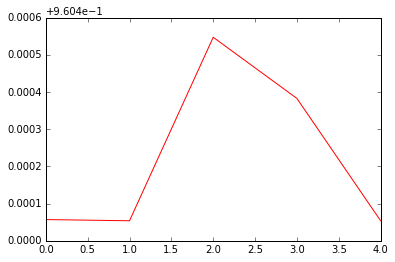

Scores =  [ 0.96045709  0.96045384  0.96094713  0.9607827   0.96045384]


In [15]:
cvd = {}

#scores = cross_validation.cross_val_score(model_rfc, X_train, y_train, cv = kcv)
#cvd['RandomForestClassifier'] = scores

scores = cross_validation.cross_val_score(model_xgb, X_train, y_train, cv = KCV, n_jobs = -1)
#cvd['XGBClassifier'] = scores

#plt.plot(range(len(scores)), cvd['RandomForestClassifier'], 'b', range(len(scores)), cvd['XGBClassifier'], 'r')
plt.plot(range(len(scores)), scores, 'r')
plt.show()

print("Scores = ", scores)

In [16]:
fitted_xgb = model_xgb.fit(X_train, y_train)

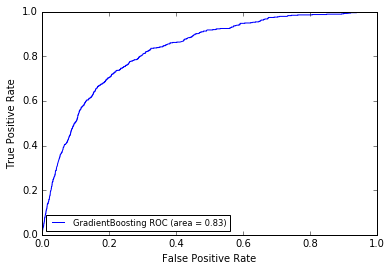

In [17]:
pl.clf()

gb_probas = fitted_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, gb_probas[:, 1])
roc_auc  = auc(fpr, tpr)
pl.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('GradientBoosting',roc_auc))

pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.legend(loc=0, fontsize='small')
pl.show()

In [18]:
result = DataFrame(testdata['ID'])
pred_xgb = fitted_xgb.predict_proba(ctestdata)[:, 1]
result.insert(1,'TARGET', pred_xgb)
result.to_csv('~/ml/kaggle_santander_happy_customers/res_xgb.csv', index=False)